In [1]:
import numpy as np
from scipy import io
from spdnet_init_afew import spdnet_init_afew
from spdnet.utils.load_data import load_data
from accumulate_gradients import accumulate_gradients
from spdnet.vl_folder.vl_myforbackward import vl_myforbackward

from os import listdir
import os

from sklearn.utils import shuffle

import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm

# Load data

**We implemented function that takes matlab matrices from the source http://www.vision.ee.ethz.ch/%7Ezzhiwu/codes/original and produce data in numpy formats. If you would like to use initial data, just uncomment lines beyond. In this code we assume that data has already exist in your folder.**

# Uncomment this for the first time!

In [2]:
#train_data, train_labels = load_data('train')
#val_data, val_labels = load_data('val')

In [3]:
#print(train_data.shape, train_labels.shape, val_data.shape, val_labels.shape)

In [4]:
#X_train, y_train = shuffle(train_data, train_labels, random_state=123)
#X_val, y_val = shuffle(val_data, val_labels, random_state=123)

In [5]:
#np.save('X_train', X_train)
#np.save('X_val', X_val)
#np.save('y_train', y_train)
#np.save('y_val', y_val)

# Uncomment above code for the first time!

In [6]:
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')

# Additional functions

In [7]:
def iterate_minibathces(X, y, batchsize):
    """
    X = 3-dim tensor (data_size, rows=400, cols=400)
    """
    indices = np.random.permutation(np.arange(X.shape[0]))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [8]:
def calculate_error(true_labels, predictions, print_result = False):
    
    ind = np.argsort(-predictions, axis = 1)[:, 0]
    answer = np.sum(ind != true_labels - 1)
    
    if print_result:
        print("true_labels", true_labels)
        u, indices = np.unique(true_labels, return_counts=True)
        print("Must_have", u[np.argmax(indices)])
        print("ind", ind)
    
    return answer / predictions.shape[0]

# Training

# Parameters
**These parameters are taken from original paper.**

In [9]:
opts = {}

opts['batchSize'] = 30
opts['test_batchSize'] = 1
opts['numEpochs'] = 80
opts['learningRate'] = 0.01 * np.ones(opts['numEpochs'])
opts['weightDecay'] = 0.05
opts['continue'] = 1


# Second experiment

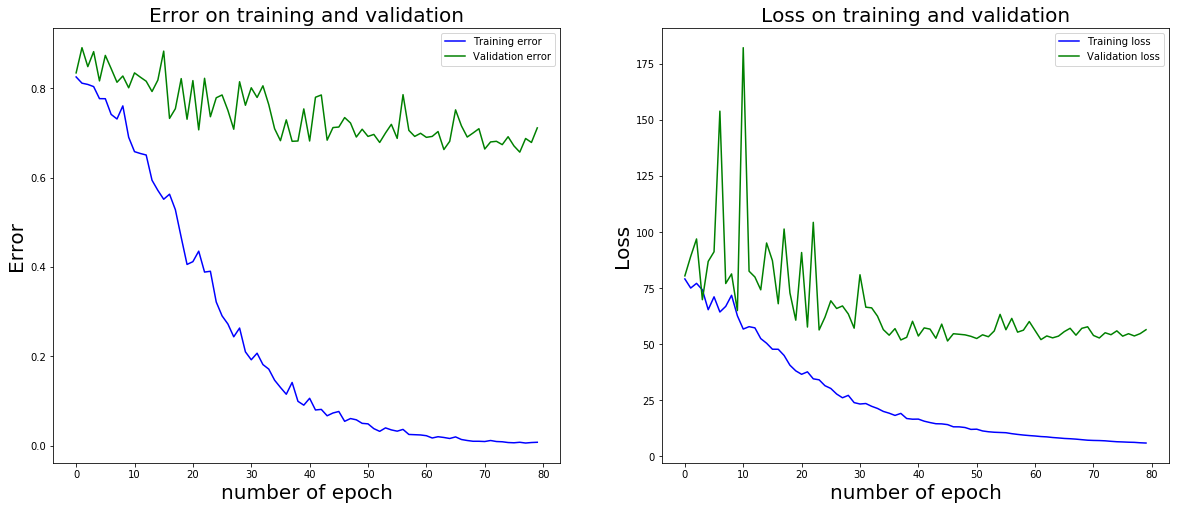

Epoch 80 of 80 took 71.593s
  training error: 	0.007910
  validation error: 	0.711655 
  training loss: 	5.980402
  validation loss: 	56.529143 


In [10]:
num_epochs = opts['numEpochs']

net = spdnet_init_afew()


train_error = []
val_error = []

train_loss = []
val_loss = []

try:
    
    for epoch in range(opts['numEpochs']):

        start_time = time.time()

        train_error_per_epoch = []
        val_error_per_epoch = []
        
        train_loss_per_epoch = []
        val_loss_per_epoch = []

        zz = 0
        
        # training mode
        net['train_mode'] = True

        for X_batch, y_batch in iterate_minibathces(X_train, y_train, opts['batchSize']):
            print('batch num: ', zz + 1)

            net['layers'][-1]['class'] = y_batch
            res = vl_myforbackward(net=net, x=X_batch, dzdy=1, res=None, varargin=None)
            [net, res] = accumulate_gradients(opts=None, lr=opts['learningRate'][epoch], 
                                              batchSize=X_batch.shape[0], net=net, res=res)
            predictions = res['x'][-2]

            train_error_per_epoch.append(calculate_error(y_batch, predictions))
            train_loss_per_epoch.append(res['x'][-1])

            zz += 1


        train_error.append(np.mean(train_error_per_epoch))
        train_loss.append(np.mean(train_loss_per_epoch))

       
        # test mode
        net['train_mode'] = False

        for X_batch, y_batch in iterate_minibathces(X_val, y_val, opts['batchSize']):
            net['layers'][-1]['class'] = y_batch
            res = vl_myforbackward(net=net, x=X_batch, dzdy=None, res=None)
  
            predictions = res['x'][-2]

            val_error_per_epoch.append(calculate_error(y_batch, predictions))
            val_loss_per_epoch.append(res['x'][-1])


        val_error.append(np.mean(val_error_per_epoch))
        val_loss.append(np.mean(val_loss_per_epoch))
        
        # Visualize and print the results

        display.clear_output(wait=True)
        
        # Visualize
        
        fig = plt.figure(figsize=(20, 8))
        plot1 = fig.add_subplot(121)
        plot2 = fig.add_subplot(122)
        
        
        plot1.set_title("Error on training and validation", size = 20)
        plot1.set_xlabel("number of epoch", size = 20)
        plot1.set_ylabel("Error", size = 20)
        plot1.plot(train_error, 'b', label="Training error")
        plot1.plot(val_error, 'g', label="Validation error")
        
        plot1.legend()
        
        
        plot2.set_title("Loss on training and validation", size = 20)
        plot2.set_xlabel("number of epoch", size = 20)
        plot2.set_ylabel("Loss", size = 20)
        plot2.plot(train_loss, 'b', label="Training loss")
        plot2.plot(val_loss, 'g', label="Validation loss")
        
        plot2.legend()
        
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training error: \t{:.6f}".format(
            np.mean(train_error[-1])))
        print("  validation error: \t{:.6f} ".format(
            np.mean(val_error[-1])))
        
        print("  training loss: \t{:.6f}".format(
            np.mean(train_loss[-1])))
        print("  validation loss: \t{:.6f} ".format(
            np.mean(val_loss[-1])))
    
    
    
except KeyboardInterrupt:
    pass

# Third experiment

In this experiment we would like to increase batch size for the NN.

# U-Net architecture

In [11]:
from spdnet_init_afew_new import spdnet_init_afew_new